**João Lucas Lage Gonçalves**

**23052002**

# Descrição


# Carregar os dados

In [16]:
!pip install ftfy

  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/f4/f0/21efef51304172736b823689aaf82f33dbc64f54e9b046b75f5212d5cee7/ftfy-6.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/fd/84/fd2ba7aafacbad3c4201d395674fc6348826569da3c0937e75505ead3528/wcwidth-0.2.13-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/54.4 kB ? eta -:--:--
   ---------------------- ----------------- 30.7/54.4 kB 640.0 kB/s eta 0:00:01
   ---------------------------------------- 54.4/54.4 kB 701.5 kB/s eta 0:00:00
Using cached wcwidth-0.2.13-py2.py3-none-any.whl (34 kB)
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.5
    Uninstalling wcwidth-0.2.5:
      Successfully uninstalled wcwidth-0.2.5


In [17]:
import os
import pandas as pd
import json
import ftfy


data_path = './data/'

In [37]:
# load tags

tags = pd.read_csv(data_path + 'tags2name.csv')

tags.head()

,Tag,Label,Description
0,101,Goal,Goal
1,102,own_goal,Own goal
2,301,assist,Assist
3,302,keyPass,Key pass
4,1901,counter_attack,Counter attack


In [6]:
# Load team and player data

teams = pd.read_json(data_path + 'teams.json')
players = pd.read_json(data_path + 'players.json')

print(teams.info(), players.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          142 non-null    object
 1   name          142 non-null    object
 2   wyId          142 non-null    int64 
 3   officialName  142 non-null    object
 4   area          142 non-null    object
 5   type          142 non-null    object
dtypes: int64(1), object(5)
memory usage: 6.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3603 entries, 0 to 3602
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   passportArea           3603 non-null   object
 1   weight                 3603 non-null   int64 
 2   firstName              3603 non-null   object
 3   middleName             3603 non-null   object
 4   lastName               3603 non-null   object
 5   currentTeamId          3512 non-null   ob

In [8]:
# load event data
event_files = os.listdir(data_path)
events = pd.concat([pd.read_json(data_path + file) for file in event_files if 'events' in file])

events.info()


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
101754,8,Simple pass,[{'id': 1801}],3476,"[{'y': 20, 'x': 46}, {'y': 6, 'x': 64}]",2058017,Pass,9598,2H,2978.301867,85,263885652
101755,7,Touch,[],14812,"[{'y': 6, 'x': 64}, {'y': 2, 'x': 82}]",2058017,Others on the ball,9598,2H,2979.084611,72,263885653
101756,8,Cross,"[{'id': 401}, {'id': 801}, {'id': 1802}]",14812,"[{'y': 2, 'x': 82}, {'y': 100, 'x': 100}]",2058017,Pass,9598,2H,2983.448628,80,263885654
101757,4,Goalkeeper leaving line,[],25381,"[{'y': 0, 'x': 0}, {'y': 98, 'x': 18}]",2058017,Goalkeeper leaving line,4418,2H,2985.869275,40,263885613


# EDA

In [ ]:
print(teams.area.unique())
print(teams.info())
teams.head()

Axes(0.125,0.11;0.775x0.77)
['Turkey' 'Senegal' 'France' 'Netherlands' 'Belgium' 'Denmark' 'Austria'
 'Iceland' 'Finland' 'Cura\\u00e7ao' 'Poland' 'Brazil' 'Iraq' 'Ghana'
 'Sweden' 'Morocco' 'Serbia' 'Slovakia' "C\\u00f4te d'Ivoire" 'Venezuela'
 'Italy' 'Nigeria' 'Korea Republic' 'Gambia' 'Romania' 'Switzerland'
 'Congo DR' 'England' 'Algeria' 'Argentina' 'Japan' 'Congo' 'Spain'
 'Russia' 'Burkina Faso' 'Croatia' 'Lithuania' 'Germany' 'Mali' 'Uruguay'
 'Afghanistan' 'Egypt' 'Mauritania' 'New Caledonia' 'Albania' 'Peru'
 'Czech Republic' 'Paraguay' 'Portugal' 'Martinique' 'Tunisia' 'Angola'
 'Colombia' 'Costa Rica' 'Iran' 'Cape Verde Islands' 'Kenya' 'Mexico'
 'Chile' 'Chad' 'Dominican Republic' 'China PR' 'Greece' 'Hungary'
 'Slovenia' 'Bosnia-Herzegovina' 'Honduras' 'Mozambique' 'Togo' 'Cameroon'
 'South Africa' 'Jamaica' 'Burundi' 'Eritrea' 'Guinea' 'Ukraine' 'Reunion'
 'Wales' 'Montenegro' 'Suriname' 'Guyana' 'Benin' 'Ireland Republic'
 'Macedonia FYR' 'Libya' 'Korea DPR' 'Comoros' 

,playerId,name,shortName,area,position,age,teamId
0,32777,Harun Tekin,H. Tekin,Turkey,GK,35,4502
1,393228,Malang Sarr,M. Sarr,Senegal,DF,25,3775
2,393230,Over Mandanda,O. Mandanda,France,GK,25,3772
3,32793,Alfred John Momar N'Diaye,A. N'Diaye,Senegal,MD,34,683
4,393247,Ibrahima Konaté,I. Konaté,France,DF,25,2975


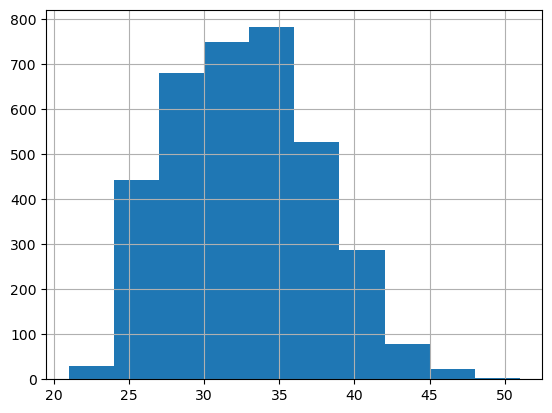

In [34]:
print(players.age.hist())
print(players.area.unique())
print(players.info())
players.head()

In [46]:
print(events.eventName.unique())
print(events.info())
events.head()

['Pass' 'Duel' 'Foul' 'Free Kick' 'Shot' 'Save attempt'
 'Others on the ball' 'Interruption' 'Goalkeeper leaving line' 'Offside']
<class 'pandas.core.frame.DataFrame'>
Index: 3251294 entries, 0 to 101758
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   eventId      int64  
 1   eventName    object 
 2   teamId       int64  
 3   playerId     int64  
 4   matchId      int64  
 5   matchPeriod  object 
 6   eventSec     float64
 7   start_x      int64  
 8   start_y      int64  
 9   end_x        float64
 10  end_y        float64
 11  tags         object 
dtypes: float64(3), int64(6), object(3)
memory usage: 322.5+ MB
None


,eventId,eventName,teamId,playerId,matchId,matchPeriod,eventSec,start_x,start_y,end_x,end_y,tags
0,8,Pass,1609,25413,2499719,1H,2.758649,49,49,31.0,78.0,[1801]
1,8,Pass,1609,370224,2499719,1H,4.946850,31,78,51.0,75.0,[1801]
2,8,Pass,1609,3319,2499719,1H,6.542188,51,75,35.0,71.0,[1801]
3,8,Pass,1609,120339,2499719,1H,8.143395,35,71,41.0,95.0,[1801]
4,8,Pass,1609,167145,2499719,1H,10.302366,41,95,72.0,88.0,[1801]


# Tratamento de dados

In [30]:
teams['name'] = teams['name'].str.decode('unicode-escape')
teams['officialName'] = teams['officialName'].str.decode('unicode-escape')
teams['area'] = teams['area'].apply(lambda x: x['name'])
teams['area'] = teams['area'].str.decode('unicode-escape')
teams = teams[['wyId', 'name', 'area']]
teams.rename(columns={'wyId': 'teamId', 'name': 'teamName', 'area': 'teamCountry'}, inplace=True)

['England' 'Spain' 'France' 'Germany' 'Italy' 'Wales' 'Monaco'
 'Korea Republic' 'Hungary' 'Turkey' 'Russia' 'Sweden' 'Tunisia' 'Brazil'
 'Albania' 'Romania' 'Ukraine' 'Morocco' 'Slovakia' 'Colombia' 'Panama'
 'Australia' 'Argentina' 'Northern Ireland' 'Portugal' 'Belgium' 'Denmark'
 'Uruguay' 'Costa Rica' 'Egypt' 'Japan' 'Iran' 'Austria' 'Iceland'
 'Croatia' 'Mexico' 'Ireland Republic' 'Czech Republic' 'Senegal' 'Peru'
 'Saudi Arabia' 'Serbia' 'Switzerland' 'Poland' 'Nigeria']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teamId  142 non-null    int64 
 1   name    142 non-null    object
 2   area    142 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.5+ KB
None


,teamId,name,area
0,1613,Newcastle United,England
1,692,Celta de Vigo,Spain
2,691,Espanyol,Spain
3,696,Deportivo AlavÃÂÃÂÃÂÃÂÃÂÃÂÃÂÃÂ©s,Spain
4,695,Levante,Spain


In [32]:
players.head()

players['shortName'] = players['shortName'].str.decode('unicode-escape')
players['firstName'] = players['firstName'].str.decode('unicode-escape')
players['lastName'] = players['lastName'].str.decode('unicode-escape')

players['name'] = players['firstName'] + ' ' + players['lastName']
players['area'] = players['passportArea'].apply(lambda x: x['name'])
players['area'] = players['area'].str.decode('unicode-escape')
players['position'] = players['role'].apply(lambda x: x['code2'])
players['age'] = (pd.to_datetime('today') - pd.to_datetime(players['birthDate'])) // pd.Timedelta(days=365.25)

players = players[['wyId', 'name', 'shortName', 'area', 'position', 'age','currentTeamId']]

players.rename(columns={'wyId': 'playerId', 'currentTeamId': 'teamId', 'name': 'playerName', 'area': 'playerCountry'}, inplace=True)


,playerId,name,shortName,area,position,age,teamId
0,32777,Harun Tekin,H. Tekin,Turkey,GK,35,4502
1,393228,Malang Sarr,M. Sarr,Senegal,DF,25,3775
2,393230,Over Mandanda,O. Mandanda,France,GK,25,3772
3,32793,Alfred John Momar N'Diaye,A. N'Diaye,Senegal,MD,34,683
4,393247,Ibrahima Konaté,I. Konaté,France,DF,25,2975


In [45]:
events.head()

events['start_x'] = events['positions'].apply(lambda x: x[0]['x'])
events['start_y'] = events['positions'].apply(lambda x: x[0]['y'])
events['end_x'] = events['positions'].apply(lambda x: x[1]['x'] if len(x) > 1 else None)
events['end_y'] = events['positions'].apply(lambda x: x[1]['y'] if len(x) > 1 else None)
#events['tags'] = events['tags'].apply(lambda x: [tag['id'] for tag in x])

events = events[['eventId', 'eventName', 'teamId', 'playerId', 'matchId', 'matchPeriod', 'eventSec', 'start_x', 'start_y', 'end_x', 'end_y', 'tags']]


events.head()



,eventId,eventName,teamId,playerId,matchId,matchPeriod,eventSec,start_x,start_y,end_x,end_y,tags
0,8,Pass,1609,25413,2499719,1H,2.758649,49,49,31.0,78.0,[1801]
1,8,Pass,1609,370224,2499719,1H,4.946850,31,78,51.0,75.0,[1801]
2,8,Pass,1609,3319,2499719,1H,6.542188,51,75,35.0,71.0,[1801]
3,8,Pass,1609,120339,2499719,1H,8.143395,35,71,41.0,95.0,[1801]
4,8,Pass,1609,167145,2499719,1H,10.302366,41,95,72.0,88.0,[1801]


# Feature Engineering

In [47]:
print("oi")

oi
